# Iranian Telecom Customer Churn Prediction

This Jupyter notebook aims to predict customer churn using a dataset that includes various customer attributes. The notebook covers data preprocessing, exploratory data analysis (EDA), visualization of the dataset and churn prediction models.

## Setup

We start by importing the necessary libraries and loading the dataset:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')
import seaborn as sns
from ydata_profiling import ProfileReport

In [2]:
# Load the dataset

df = pd.read_csv('Customer Churn.csv')
df.head()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0


## Dataset Overview

The dataset contains the following features:

+ **Call Failures:** number of call failures
+ **Complains:** binary (0: No complaint, 1: complaint)
+ **Subscription Length:** total months of subscription
+ **Charge Amount:** Ordinal attribute (0: lowest amount, 9: highest amount)
+ **Seconds of Use:** total seconds of calls
+ **Frequency of use:** total number of calls
+ **Frequency of SMS:** total number of text messages
+ **Distinct Called Numbers:** total number of distinct phone calls 
+ **Age Group:** ordinal attribute (1: younger age, 5: older age)
+ **Tariff Plan:** binary (1: Pay as you go, 2: contractual)
+ **Status:** binary (1: active, 2: non-active)
+ **Customer Value:** The calculated value of customer
+ **Churn:** binary (1: churn, 0: non-churn) - Class label

## Data Preprocessing

We start by renaming the columns to make them more consistent:

In [3]:
## Function to rename properly the columns
def rename_features(feature_name: str) -> str:
    # Get rid of the leading and trailing whitespaces
    new_name = feature_name.strip()

    # Lower case only
    new_name = new_name.lower()

    # Replace the double spaces with only one
    new_name = new_name.replace('  ', ' ')

    # Finally replace the spaces with underscores
    new_name = new_name.replace(' ', '_')

    return new_name


In [4]:
rename_dict = {}

features_list = df.columns.to_list()

for feature in features_list:
    rename_dict[feature] = rename_features(feature)
    
df = df.rename(columns=rename_dict)

## Exploratory Data Analysis (EDA)

Now, let's explore the data with some visualizations:

### Distribution Plots

We create distribution plots for each feature to understand the data distribution:

In [5]:
profile = ProfileReport(df, title='Profiling Report')
# profile.to_notebook_iframe()
# profile.to_file("churn_report.html")

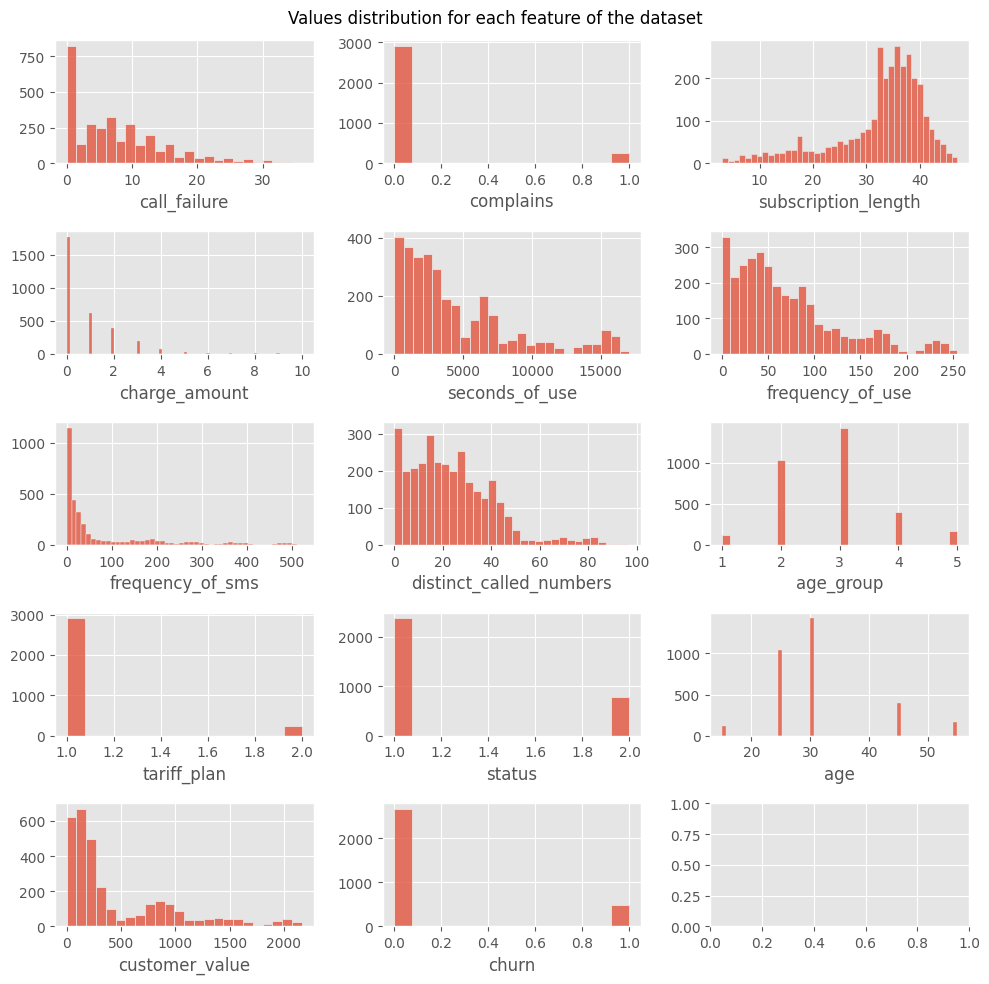

In [6]:
fig, axes = plt.subplots(5, 3, figsize=(10, 10))
fig.suptitle('Values distribution for each feature of the dataset')

for i, col in enumerate(df.columns):
    ax = axes[i//3, i%3]
    sns.histplot(ax=ax, data=df, x=col)
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

### Box Plots

We use box plots to visualize the spread of data and identify potential outliers:

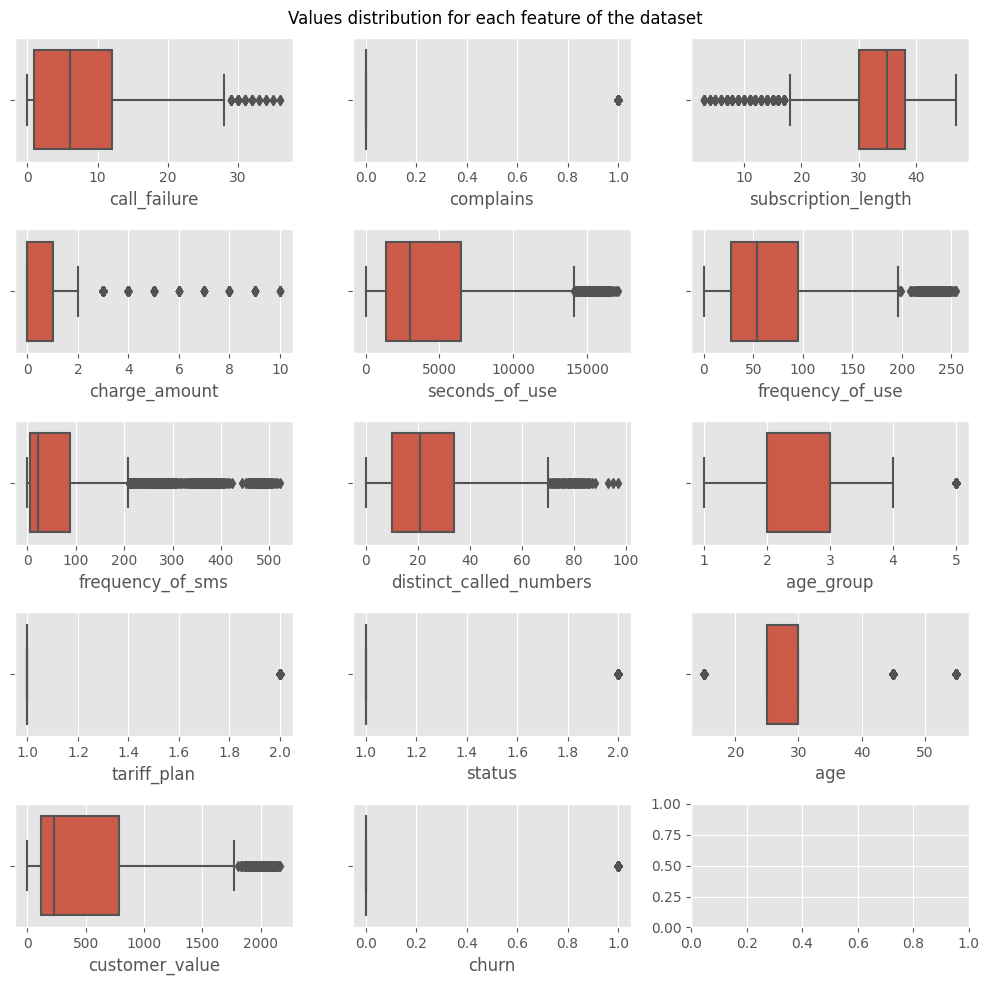

In [7]:
fig, axes = plt.subplots(5, 3, figsize=(10, 10))
fig.suptitle('Values distribution for each feature of the dataset')

for i, col in enumerate(df.columns):
    sns.boxplot(ax=axes[i//3, i%3], data=df, x=col)

plt.tight_layout()
plt.show()

### Correlation Heatmap

To understand the correlation between features, we create a heatmap:dd

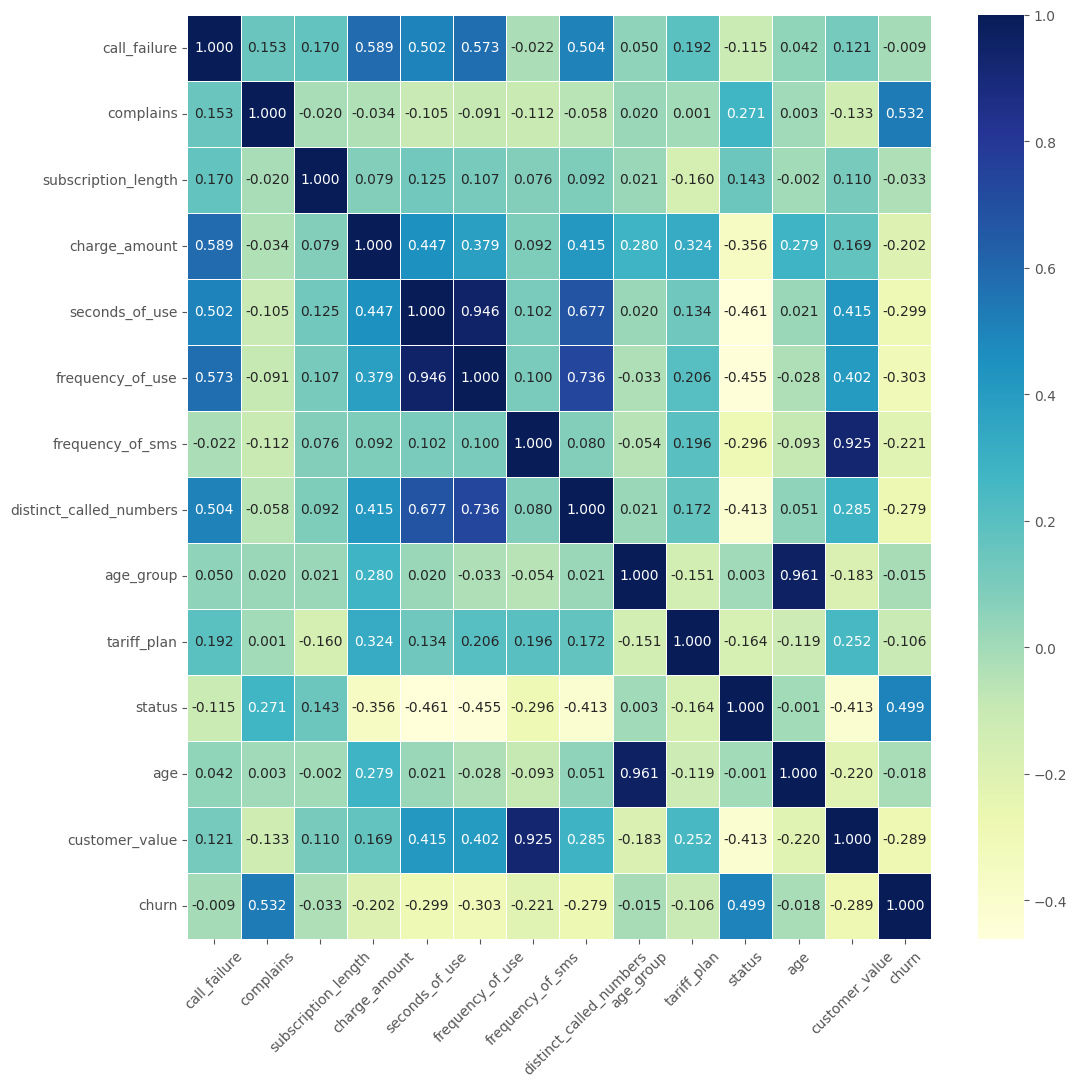

In [8]:
plt.figure(figsize=(12,12))

sns.heatmap(df.corr(), annot=True, cmap='YlGnBu', fmt='.3f', linewidths=.7)
plt.yticks(rotation=0)
plt.xticks(rotation=45)

plt.show()

### Feature Removal

We identify that 'age_group' is highly correlated with 'age,' so we decide to drop 'age_group':

In [9]:
df = df.drop(columns='age_group')

### Pairplot

We create a pairplot to visualize relationships between features, focusing on selected continuous columns:

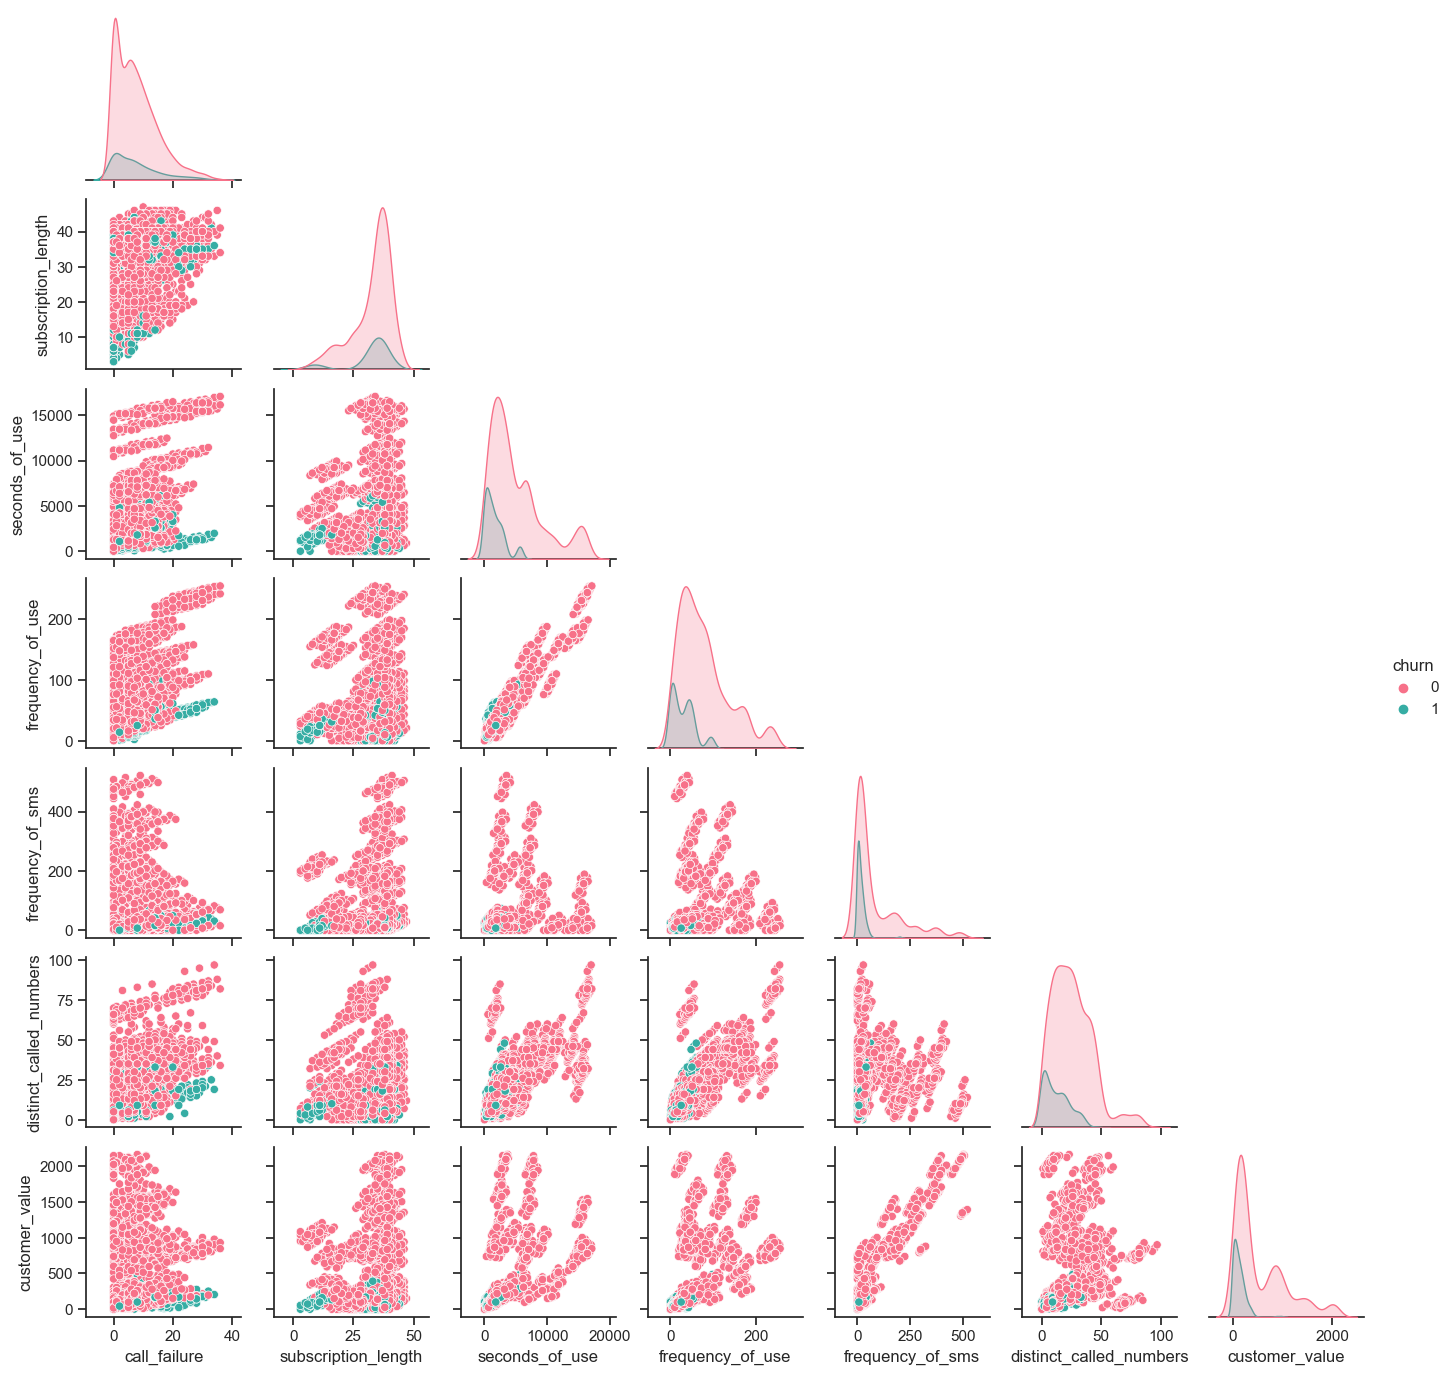

In [10]:
__needed_cols = ['call_failure', 'subscription_length', 'seconds_of_use', 'frequency_of_use', 'frequency_of_sms', 'distinct_called_numbers','customer_value', 'churn']

sns.set(style="ticks")
sns.pairplot(data = df[__needed_cols], palette='husl', hue='churn', hue_order=[0,1], corner=True, height=2)

# Model Development

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, CategoricalNB
from sklearn.svm import LinearSVC,SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import learning_curve

In [12]:
X = df.drop(columns=['churn'])
y = df['churn']

### Define the pipelines for the different models

In [22]:
pipelines ={

    'KNN': Pipeline([
    ('scaler', StandardScaler()),
    ('model', KNeighborsClassifier())
    ]),

    'SVM': Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVC())
    ]),

    'Decision Tree': Pipeline([
    ('scaler', StandardScaler()),
    ('model', DecisionTreeClassifier())
    ])

}

### Classification model #1: K_Nearest Neighbors

In [16]:
start_time=time.time()

# Define the hyperparameters to tune
param_grid = {
    'knn__n_neighbors': [3, 5, 7],  # Number of neighbors to consider
    'knn__weights': ['uniform', 'distance'],  # Weighting strategy
    'knn__p': [1, 2]  # Minkowski distance parameter (1 for Manhattan, 2 for Euclidean)
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='accuracy', cv=5, verbose=2, n_jobs=-1)

# Fit the grid search to your data
grid_search.fit(X, y)

# Get the best parameters and estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Print the best parameters
print("Best Hyperparameters:")
for param, value in best_params.items():
    print(f'{param}: {value}')

# Access the best estimator (trained model) for further use
best_model = best_estimator.named_steps['knn']

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Hyperparameters:
knn__n_neighbors: 7
knn__p: 1
knn__weights: distance
